# Deep Learning

## Examen Agosto 2022

## Ejercicio 2 - Parte 2 (regularización del modelo)

Utilizando el mismo dataset que en el link anterior, diseñar una red neuronal que haga un overfitting sobre el dataset. ¿Cómo saben que la red neuronal está haciendo overfitting? Agregar regularización y encontrar los parámetros correctos para lograr un buen fit. Explicar el procedimiento realizado.

### Librerías y funciones globales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn import metrics

### Lectura de datos y creación de dataloaders

In [2]:
df = pd.read_csv('data/dataset_1.csv')

In [3]:
x= df["# X"].to_numpy()
y= df["Y"].to_numpy()

In [4]:
n = x.shape[0]
idx = np.random.permutation(np.arange(0, n))
train_idx = idx[0:int(0.80 * n)]
test_idx = idx[int(0.80 * n):]

In [5]:
X_train = x[train_idx]
y_train = y[train_idx]
X_test = x[test_idx]
y_test = y[test_idx]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000,)
(8000,)
(2000,)
(2000,)


In [6]:
class MyDataset(Dataset):

    def __init__(self, X, y):
        super().__init__()
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [7]:
train = MyDataset(X_train, y_train)
test = MyDataset(X_test, y_test)

In [8]:
train_dataloader = DataLoader(train, batch_size=2048, shuffle=False)
test_dataloader = DataLoader(test, batch_size=2048, shuffle=False)

### Definición de la red neuronal regularizada

In [9]:
class NNet(torch.nn.Module):

    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=1, out_features=128, bias=True)
        self.relu_1 = torch.nn.ReLU()
        self.dropout_1 = torch.nn.Dropout(0.6)
        
        self.linear_2 = torch.nn.Linear(in_features=128, out_features=256, bias=True)
        self.relu_2 = torch.nn.ReLU()
        self.dropout_2 = torch.nn.Dropout(0.6)
        
        self.linear_3 = torch.nn.Linear(in_features=256, out_features=128, bias=True)
        self.relu_3 = torch.nn.ReLU()
        self.dropout_3 = torch.nn.Dropout(0.5)
        
        self.output = torch.nn.Linear(in_features=128, out_features=1, bias=True)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)
        
        x = self.linear_2(x)
        x = self.relu_2(x)
        x = self.dropout_2(x)
        
        x = self.linear_3(x)
        x = self.relu_3(x)
        x = self.dropout_3(x)
        
        x = self.output(x)
        return x

In [10]:
nnet = NNet()

In [11]:
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss()

In [12]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

print(device)

cuda:0


### Entrenamiento de la red neuronal

In [13]:
nnet.to(device)

loss_list = []
for epoch in range(100):

    running_loss = 0
    for i, data in enumerate(train_dataloader):

        # datos del batch
        X_batch, y_batch = data         
        X_batch = X_batch.to(device).float()
        Y_batch = torch.reshape(y_batch.to(device).float() , (-1,1))
        
        # forward
        optimizer.zero_grad()
        y_batch_score = nnet(torch.reshape(X_batch , (-1,1)))

        # backpropagation
        loss = loss_function(y_batch_score, Y_batch) # calcula el loss
        loss.backward() # hacer los gradientes del loss

        # actualización de parametros
        optimizer.step() 

        running_loss += loss.item()

    # metrics
    loss_list.append(running_loss)
    print(f"Epoch {epoch + 1} | Training loss: {running_loss}")

Epoch 1 | Training loss: 32.16381072998047
Epoch 2 | Training loss: 17.682133436203003
Epoch 3 | Training loss: 14.572710275650024
Epoch 4 | Training loss: 13.357031106948853
Epoch 5 | Training loss: 10.976469993591309
Epoch 6 | Training loss: 10.069599151611328
Epoch 7 | Training loss: 8.351502299308777
Epoch 8 | Training loss: 7.508324384689331
Epoch 9 | Training loss: 7.039308547973633
Epoch 10 | Training loss: 6.1918922662734985
Epoch 11 | Training loss: 5.990603089332581
Epoch 12 | Training loss: 5.471506237983704
Epoch 13 | Training loss: 5.306297659873962
Epoch 14 | Training loss: 5.16137170791626
Epoch 15 | Training loss: 5.102767825126648
Epoch 16 | Training loss: 5.017390251159668
Epoch 17 | Training loss: 4.879113554954529
Epoch 18 | Training loss: 4.774015545845032
Epoch 19 | Training loss: 4.68048095703125
Epoch 20 | Training loss: 4.719798684120178
Epoch 21 | Training loss: 4.527932643890381
Epoch 22 | Training loss: 4.463842272758484
Epoch 23 | Training loss: 4.505065560

### Prueba de la red neuronal

In [14]:
def predict(nnet, X):
    nnet.eval()
    with torch.no_grad():
        X = X.to(device).float()
        pred = nnet(torch.reshape(X , (-1,1)))
        return pred

### Prueba sobre el conjunto de train

In [15]:
X_tain_tensor = torch.from_numpy(X_train)
y_hat_train = predict(nnet, X_tain_tensor)
y_hat = y_hat_train.cpu().detach().numpy()

[]

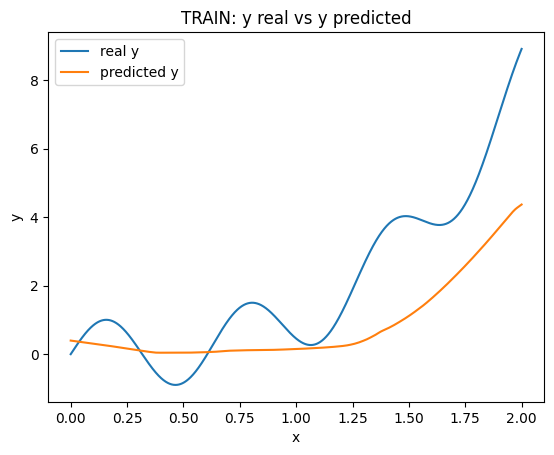

In [16]:
plot = sns.lineplot(x=np.squeeze(X_train), y=np.squeeze(y_train), label='real y')
plot = sns.lineplot(x=np.squeeze(X_train), y=np.squeeze(y_hat), label='predicted y')
plot.set(xlabel ='x', ylabel='y', title='TRAIN: y real vs y predicted')
plot.plot()

In [17]:
mse = metrics.mean_squared_error(y_train, y_hat)
print(f'MSE train: {mse}')

MSE train: 3.1050271899149005


### Prueba sobre el conjunto de test

In [18]:
X_test_tensor = torch.from_numpy(X_test)
y_hat_test = predict(nnet, X_test_tensor)
y_hat = y_hat_test.cpu().detach().numpy()

[]

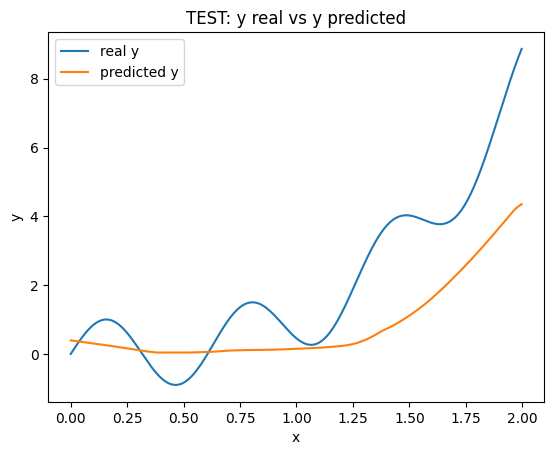

In [19]:
plot = sns.lineplot(x=np.squeeze(X_test), y=np.squeeze(y_test), label='real y')
plot = sns.lineplot(x=np.squeeze(X_test), y=np.squeeze(y_hat), label='predicted y')
plot.set(xlabel ='x', ylabel='y', title='TEST: y real vs y predicted')
plot.plot()

In [20]:
mse = metrics.mean_squared_error(y_test, y_hat)
print(f'MSE train: {mse}')

MSE train: 3.0905201018363506


### Conclusiones

Se agregaron capas de dropout entre cada una de los bloques linear + ReLu para disminuir el sobreajuste. Además, se incrementó el tamaño de los batches para intentar mejorar la generalización, como resultado, se obtiene un modelo que ajusta mejor los datos en ambos conjuntos: train y test, es posible visualizar esto en los gráficos titulados "TRAIN: y real vs y predicted" y "TEST: y real vs y predicted".